In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
import torchvision as tv
import time
BATCH_SIZE=512

In [28]:
train_dataset = tv.datasets.FashionMNIST('./fashion', train=True, transform=tv.transforms.ToTensor(), download=True)
test_dataset = tv.datasets.FashionMNIST('./fashion', train=False, transform=tv.transforms.ToTensor(), download=True)

In [29]:
train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

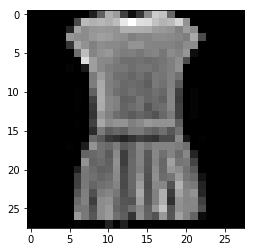

In [30]:
plt.imshow(train_dataset[3][0].numpy().reshape(28,28), cmap='gray')

In [31]:
# Постороим модель - сделаем ее глубже и добавим слои BatchNorm и DropOut

In [43]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.BatchNorm1d(784),
    torch.nn.Linear(784, 3136),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(3136),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(3136, 1568),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(1568),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(1568, 392),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(392),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(392, 10),
)

In [44]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [45]:
dev

device(type='cuda', index=0)

In [46]:
model = model.to(dev)

In [47]:
def train_model(model, num_epochs, train, test, trainer, dev):
    for ep in range(num_epochs):
        train_iters, train_passed  = 0, 0
        train_loss, train_acc = 0., 0.
    
        for X, y in train:
            X, y = X.to(dev), y.to(dev)
            trainer.zero_grad()
            y_pred = model(X)
            l = loss(y_pred, y)
            l.backward()
            trainer.step()
            train_loss += l.item()
            train_acc += (y_pred.argmax(dim=1) == y).sum().item()
            train_iters += 1
            train_passed += len(X)
    
        test_iters, test_passed  = 0, 0
        test_loss, test_acc = 0., 0.
        for X, y in test:
            X, y = X.to(dev), y.to(dev)
            y_pred = model(X)
            l = loss(y_pred, y)
            test_loss += l.item()
            test_acc += (y_pred.argmax(dim=1) == y).sum().item()
            test_iters += 1
            test_passed += len(X)
        
        print("ep: {}, train_loss: {}, train_acc: {}, test_loss: {}, test_acc: {}".format(
            ep, train_loss / train_iters, train_acc / train_passed,
            test_loss / test_iters, test_acc / test_passed)
        )

In [49]:
#Учим в несколько этапов, уменьшая lr
loss = torch.nn.CrossEntropyLoss(reduction='sum')
trainer = torch.optim.AdamW(model.parameters(), lr=0.05)
num_epochs = 10
train_model(model, num_epochs, train, test, trainer, dev)

ep: 0, train_loss: 209.9827484842074, train_acc: 0.8554666666666667, test_loss: 210.3841896057129, test_acc: 0.8496
ep: 1, train_loss: 179.0713008945271, train_acc: 0.8710166666666667, test_loss: 211.09325218200684, test_acc: 0.8542
ep: 2, train_loss: 165.96007857888432, train_acc: 0.8824166666666666, test_loss: 211.74167022705078, test_acc: 0.8503
ep: 3, train_loss: 158.96354888657393, train_acc: 0.88525, test_loss: 193.81148262023925, test_acc: 0.8635
ep: 4, train_loss: 154.1160336995529, train_acc: 0.8888, test_loss: 208.4253402709961, test_acc: 0.8563
ep: 5, train_loss: 150.6066830521923, train_acc: 0.8921166666666667, test_loss: 197.51052780151366, test_acc: 0.8583
ep: 6, train_loss: 150.64541832875398, train_acc: 0.8911666666666667, test_loss: 226.97397537231444, test_acc: 0.8483
ep: 7, train_loss: 157.0436385203216, train_acc: 0.8867333333333334, test_loss: 216.97005958557128, test_acc: 0.8556
ep: 8, train_loss: 144.3430404663086, train_acc: 0.8956333333333333, test_loss: 202.41

In [50]:
loss = torch.nn.CrossEntropyLoss(reduction='sum')
trainer = torch.optim.AdamW(model.parameters(), lr=0.005)
num_epochs = 10
train_model(model, num_epochs, train, test, trainer, dev)

ep: 0, train_loss: 108.86684000694146, train_acc: 0.9195, test_loss: 168.03835487365723, test_acc: 0.8885
ep: 1, train_loss: 97.5175813577943, train_acc: 0.9276, test_loss: 169.81521186828613, test_acc: 0.8893
ep: 2, train_loss: 90.235651210203, train_acc: 0.9332166666666667, test_loss: 169.68197021484374, test_acc: 0.8925
ep: 3, train_loss: 86.3177361084243, train_acc: 0.9351166666666667, test_loss: 175.81413688659669, test_acc: 0.8889
ep: 4, train_loss: 81.96019976017838, train_acc: 0.9389333333333333, test_loss: 181.1027629852295, test_acc: 0.889
ep: 5, train_loss: 77.24450407998036, train_acc: 0.9423833333333334, test_loss: 190.1218704223633, test_acc: 0.8893
ep: 6, train_loss: 72.90944213382268, train_acc: 0.9458333333333333, test_loss: 189.07061996459962, test_acc: 0.891
ep: 7, train_loss: 69.80571743593377, train_acc: 0.9482833333333334, test_loss: 196.55829467773438, test_acc: 0.8896
ep: 8, train_loss: 65.21881636118485, train_acc: 0.9517166666666667, test_loss: 200.96943550109

In [51]:
# Поменяем оптимизатор на AdamW для стабилизации тренировки
loss = torch.nn.CrossEntropyLoss(reduction='sum')
trainer = torch.optim.AdamW(model.parameters(), lr=0.0002)
num_epochs = 10
train_model(model, num_epochs, train, test, trainer, dev)

ep: 0, train_loss: 54.082676475330935, train_acc: 0.9595833333333333, test_loss: 206.62062377929686, test_acc: 0.8945
ep: 1, train_loss: 53.381392903247125, train_acc: 0.9600833333333333, test_loss: 202.67377586364745, test_acc: 0.8939
ep: 2, train_loss: 51.82344270560701, train_acc: 0.9616333333333333, test_loss: 215.9363597869873, test_acc: 0.8932
ep: 3, train_loss: 50.64857908022606, train_acc: 0.9626, test_loss: 208.23628349304198, test_acc: 0.8939
ep: 4, train_loss: 50.86651248446966, train_acc: 0.9632333333333334, test_loss: 208.80577812194824, test_acc: 0.8918
ep: 5, train_loss: 50.43816340171685, train_acc: 0.9621166666666666, test_loss: 210.73864250183107, test_acc: 0.8951
ep: 6, train_loss: 49.80931458634845, train_acc: 0.9632333333333334, test_loss: 211.79404258728027, test_acc: 0.8926
ep: 7, train_loss: 49.64147871631687, train_acc: 0.9635666666666667, test_loss: 212.8428783416748, test_acc: 0.8928
ep: 8, train_loss: 48.97796222719096, train_acc: 0.96415, test_loss: 213.187

In [52]:
loss = torch.nn.CrossEntropyLoss(reduction='sum')
trainer = torch.optim.AdamW(model.parameters(), lr=0.0001)
num_epochs = 30
train_model(model, num_epochs, train, test, trainer, dev)

ep: 0, train_loss: 48.13766174801325, train_acc: 0.96435, test_loss: 219.667085647583, test_acc: 0.8942
ep: 1, train_loss: 48.241349680949064, train_acc: 0.96405, test_loss: 215.93485107421876, test_acc: 0.8947
ep: 2, train_loss: 47.27962952145075, train_acc: 0.9647166666666667, test_loss: 218.63507270812988, test_acc: 0.8955
ep: 3, train_loss: 47.621523598493155, train_acc: 0.9651166666666666, test_loss: 219.56253776550292, test_acc: 0.8934
ep: 4, train_loss: 46.47283081685082, train_acc: 0.9652, test_loss: 218.2619472503662, test_acc: 0.8933
ep: 5, train_loss: 47.813264871047714, train_acc: 0.9649166666666666, test_loss: 220.659814453125, test_acc: 0.8941
ep: 6, train_loss: 46.86701483645682, train_acc: 0.9645833333333333, test_loss: 220.82618408203126, test_acc: 0.8952
ep: 7, train_loss: 47.21398870823747, train_acc: 0.9654666666666667, test_loss: 214.28051147460937, test_acc: 0.8941
ep: 8, train_loss: 46.34979126817089, train_acc: 0.96555, test_loss: 221.48496055603027, test_acc: 0

In [ ]:
#максимум на тесте - 0.8984